In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt

In [2]:
def loadVOX(filename,Frame=None,Verbose=False,Only_Info=False):
    I=[]
    cbuffer=str()
    abb = False
    
    patterns = ['VolumeSize','VolumeScale','Field']
    
    with open(filename, 'rb') as f:
        while not abb:
            v = f.read(1)
            
            if (v==b'\x00'):
                abb=True
            try:
                b=v.decode("utf-8")
            except:
                b=''
            if b=='\n':
                if Verbose:
                    print(cbuffer)

                befNr = -1
                for i in range(0,len(patterns)):
                    if patterns[i] in cbuffer:
                        befNr=i
                if befNr > -1:
                    param=cbuffer.split(' ',1)[1]                    
                    if befNr == 0:
                        w = int(param.split(' ')[0])
                        h = int(param.split(' ')[1])
                        frames = int(param.split(' ')[2])
                    elif befNr == 1:
                        vsx = float(param.split(' ')[0])
                        vsy = float(param.split(' ')[1])
                        vsz = float(param.split(' ')[2])
                        pass
                    elif befNr == 2:
                        pass
                    
                cbuffer=str()                
            elif not abb:
                cbuffer=cbuffer.__add__(b)
        
        if not Only_Info:
            size=os.path.getsize(filename)        
            if Frame == None:
                f.seek(size-w*h*frames*2)                
                I=np.reshape(np.frombuffer(f.read(w*h*frames*2),dtype='ushort'),(w,h,frames),order='F').swapaxes(0,1)
            else:
                f.seek(size-w*h*(frames-Frame)*2)                
                I=np.reshape(np.frombuffer(f.read(w*h*2),dtype='ushort'),(w,h),order='F')
                
        f.close()
        
    return I,{'image_type':'uint16','width':w,'height':h,'frames':frames,'scaling':(vsx,vsy,vsz)} 

In [3]:
Is = [  loadVOX('.\CT_20230727_152106\CT_20230727_152106.VOX'), 
        loadVOX('.\CT_20230727_152454\CT_20230727_152454.VOX'), 
        loadVOX('.\CT_20230727_152839\CT_20230727_152839.VOX')]

<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:3: SyntaxWarning: invalid escape sequence '\C'
<>:1: SyntaxWarning: invalid escape sequence '\C'
<>:2: SyntaxWarning: invalid escape sequence '\C'
<>:3: SyntaxWarning: invalid escape sequence '\C'
C:\Users\jihoo\AppData\Local\Temp\ipykernel_38600\2927188828.py:1: SyntaxWarning: invalid escape sequence '\C'
  Is = [  loadVOX('.\CT_20230727_152106\CT_20230727_152106.VOX'),
C:\Users\jihoo\AppData\Local\Temp\ipykernel_38600\2927188828.py:2: SyntaxWarning: invalid escape sequence '\C'
  loadVOX('.\CT_20230727_152454\CT_20230727_152454.VOX'),
C:\Users\jihoo\AppData\Local\Temp\ipykernel_38600\2927188828.py:3: SyntaxWarning: invalid escape sequence '\C'
  loadVOX('.\CT_20230727_152839\CT_20230727_152839.VOX')]


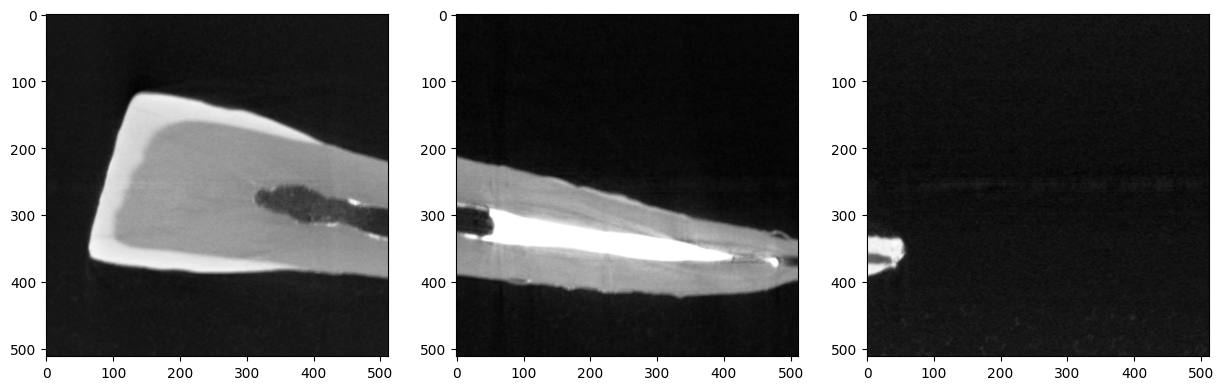

In [5]:
fix, axes = plt.subplots(1,3,figsize=(15,5))

for i in range(3):
    axes[i].imshow(Is[i][0][:,256,:],cmap='Greys_r')

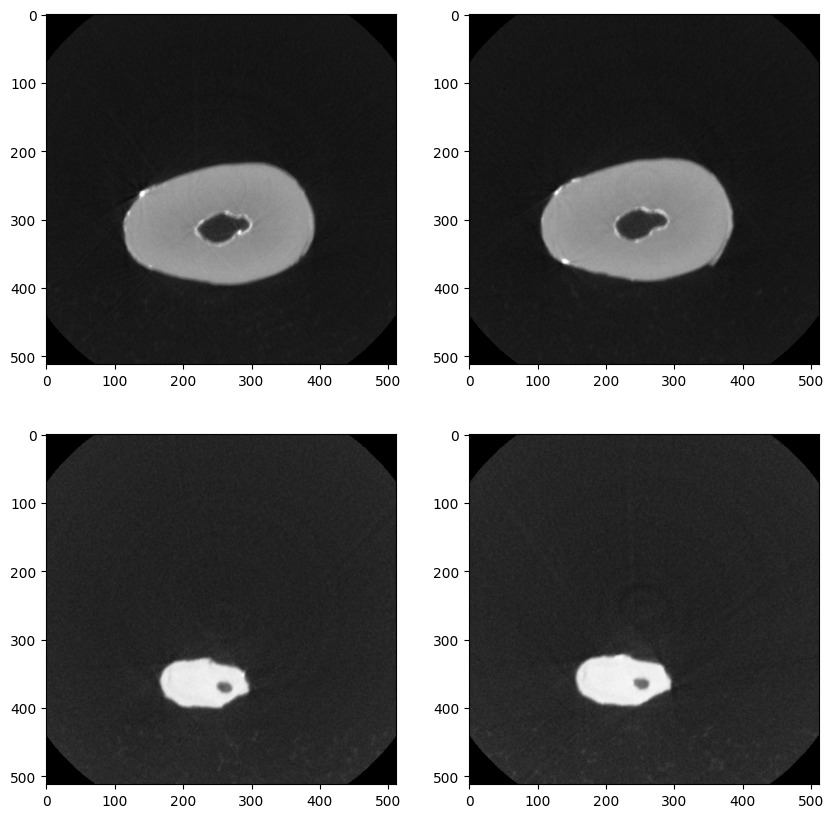

In [6]:
fix, axes = plt.subplots(2,2,figsize=(10,10))

axes[0,0].imshow(Is[0][0][:,:,-1],cmap='Greys_r')
axes[0,1].imshow(Is[1][0][:,:,0],cmap='Greys_r')
axes[1,0].imshow(Is[1][0][:,:,-1],cmap='Greys_r') 
axes[1,1].imshow(Is[2][0][:,:,0],cmap='Greys_r')

In [7]:
def z_norm(I):
    I = I.astype(np.float32)
    return (I - I.mean()) / (I.std() + 1e-8)

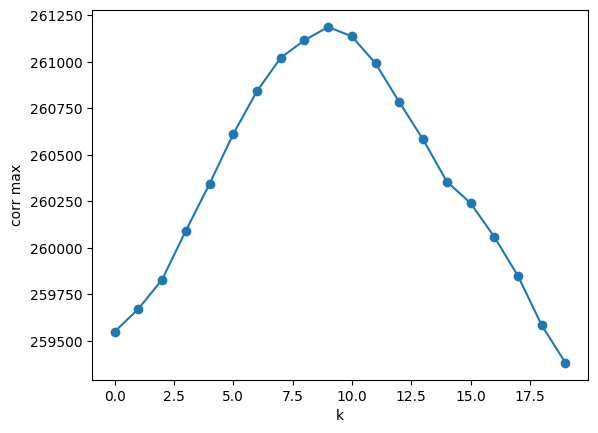

-10


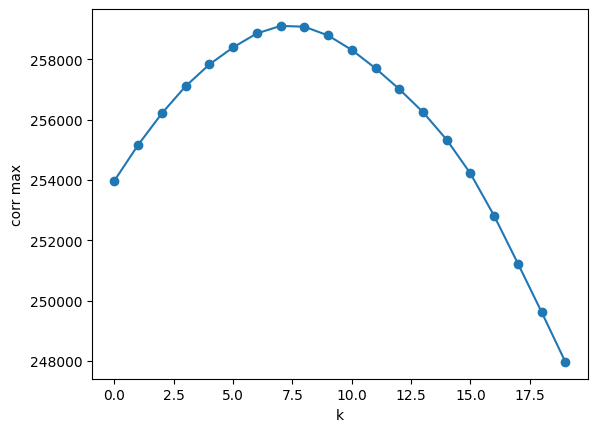

7


In [8]:
def finding_Overlap (base, target, first_mid):
    
    K = 20
    corr_max = []

    if first_mid:

        I1 = z_norm(base[:,:,0])

        for k in range(1, K+1):
            I2 = z_norm(target[:,:,-k])

            I2M = np.fliplr(np.flipud(I2))
            F = np.fft.fft2(I1)
            F2M = np.fft.fft2(I2M)

            COR = np.fft.fftshift(np.fft.ifft2(np.multiply(F,F2M)))
            max_corr_value = np.max(np.abs(COR))
            corr_max.append(max_corr_value)

        idx = - (corr_max.index(max(corr_max)) + 1)
    
    else:

        I1 = z_norm(base[:,:,-1])

        for k in range(0, K):
            I2 = z_norm(target[:,:,k])

            I2M = np.fliplr(np.flipud(I2))
            F = np.fft.fft2(I1)
            F2M = np.fft.fft2(I2M)

            COR = np.fft.fftshift(np.fft.ifft2(np.multiply(F,F2M)))
            max_corr_value = np.max(np.abs(COR))
            corr_max.append(max_corr_value)

        idx = corr_max.index(max(corr_max))
    
    plt.plot(corr_max, marker='o')
    plt.xlabel('k')
    plt.ylabel('corr max')
    plt.show()
    print(idx)

    return idx, max(corr_max)

first_mid_idx, first_mid_diff = finding_Overlap(Is[1][0], Is[0][0], True)
mid_last_idx, mid_last_diff = finding_Overlap(Is[1][0], Is[2][0], False)

translation =  7.0  , 4.0
translation =  -5.0  , -5.0


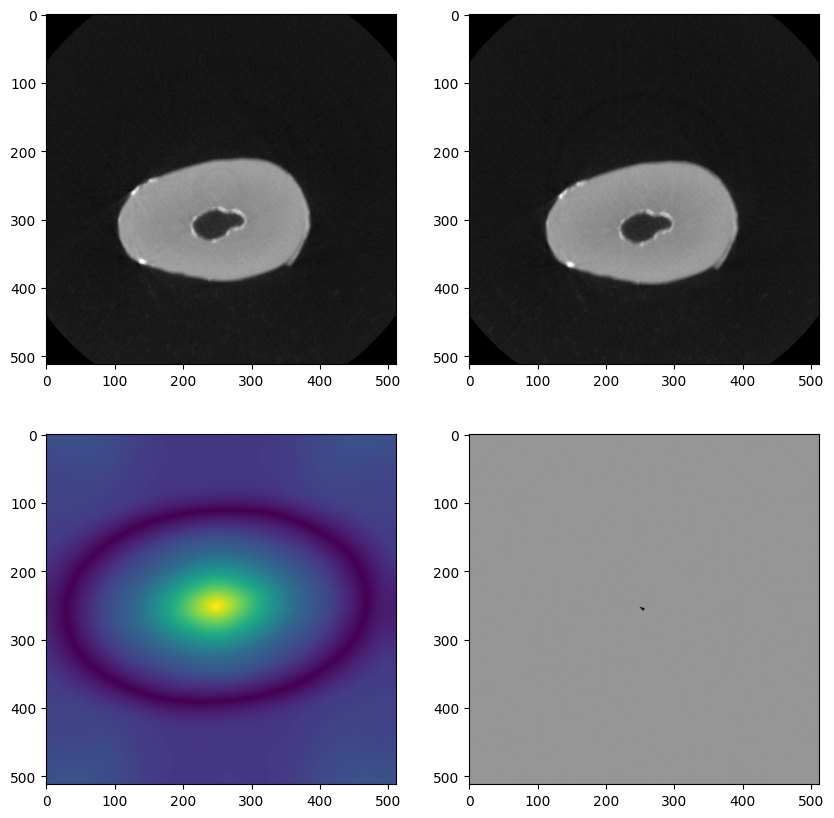

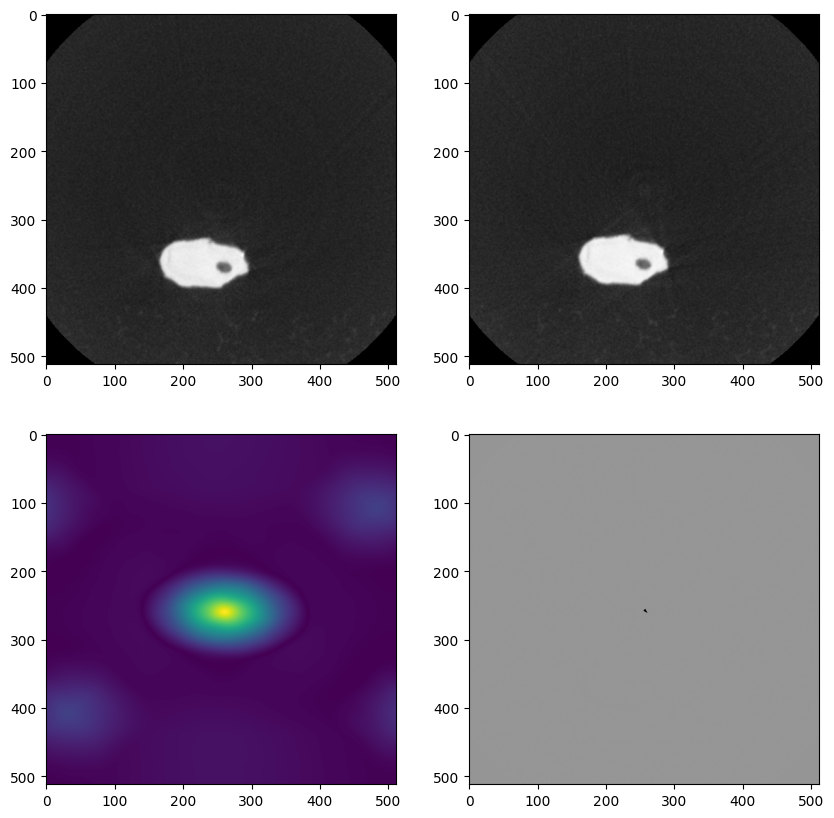

In [9]:
import cv2 as cv

def translation (base_slide, target_slide):

    fig, ax = plt.subplots(figsize=(10, 10), ncols=2, nrows=2)

    I1 = z_norm(base_slide)
    I2 = z_norm(target_slide)

    ax[0][0].imshow(I1,cmap='Greys_r')
    ax[0][1].imshow(I2,cmap='Greys_r')

    I2M = np.fliplr(np.flipud(I2))
    F = np.fft.fft2(I1)
    F2M = np.fft.fft2(I2M)

    COR = np.fft.fftshift(np.fft.ifft2(np.multiply(F,F2M)))

    p = np.where(COR == np.max(np.reshape(COR,COR.shape[0]*COR.shape[1])))
    x = COR.shape[1]/2-p[1]-1
    y = COR.shape[0]/2-p[0]-1

    print('translation = ',x[0],' ,',y[0])

    ax[1][0].imshow(np.absolute(COR))

    T = np.float32([[1, 0, -(COR.shape[1]/2-float(p[1][0])-1)],
                    [0, 1, -(COR.shape[0]/2-float(p[0][0])-1)]])
    I2T=cv.warpAffine(I2, T, (I2.shape[1], I2.shape[0]))

    ax[1][1].imshow(I1-I2T,cmap='Greys_r',vmin=-255,vmax=255)
    ax[1][1].quiver(COR.shape[0]/2,COR.shape[1]/2, 
                    -(COR.shape[1]/2-p[1]-1),COR.shape[0]/2-p[0]-1,
                    units='x',scale_units='x',scale=1.0)

    return x[0] , y[0]

first_mid_x, first_mid_y = translation(Is[1][0][:,:,0], Is[0][0][:,:,first_mid_idx])
mid_last_x, mid_last_y = translation(Is[1][0][:,:,-1], Is[2][0][:,:,mid_last_idx])


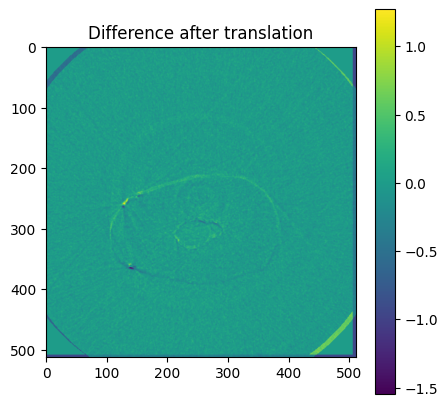

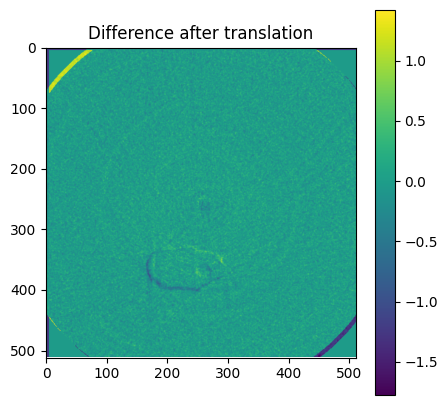

In [10]:
def visualize_drift(base_slide, target_slide, x, y):

    base_slide = z_norm(base_slide)
    target_slide = z_norm(target_slide)

    org_target = target_slide.astype(np.float32)

    target_shifted = cv.warpAffine(
        target_slide,
        np.float32([[1, 0, -x], [0, 1, -y]]),
        (org_target.shape[1], org_target.shape[0]),
        flags=cv.INTER_LINEAR,
        borderMode=cv.BORDER_CONSTANT,
        borderValue=0
    )

    plt.figure(figsize=(5,5))
    plt.imshow(base_slide - target_shifted)
    plt.colorbar()
    plt.title('Difference after translation')
    plt.show()

visualize_drift(Is[1][0][:,:,0], Is[0][0][:,:,first_mid_idx], first_mid_x, first_mid_y)
visualize_drift(Is[1][0][:,:,-1], Is[2][0][:,:,mid_last_idx], mid_last_x, mid_last_y)

In [11]:
from scipy.ndimage import shift

def shifting(target, x, y):
   return shift(target, shift=(-y, -x, 0), order=1) 

def merging(base, target_shifted, overlap_idx, first_mid):

   if first_mid:

      left  = target_shifted[:, :, :overlap_idx]
      right = base

      return np.concatenate([left, right], axis=2)

   else:

      left  = base
      right = target_shifted[:, :, overlap_idx:]

      return np.concatenate([left, right], axis=2)


first_shifted = shifting(Is[0][0], first_mid_x, first_mid_y)
first_mid_merged = merging(Is[1][0], first_shifted, first_mid_idx, True)

last_shifted = shifting(Is[2][0], mid_last_x, mid_last_y)
full_merged = merging(first_mid_merged, last_shifted, mid_last_idx, False)

In [12]:
import pyvista as pv

def numpy_to_pyvista_image(I_yxz, scaling):
    I_xyz = np.transpose(I_yxz, (1, 0, 2))
    grid = pv.ImageData(dimensions=I_xyz.shape, spacing=scaling, origin=(0.0, 0.0, 0.0))
    grid.point_data["intensity"] = I_xyz.ravel(order="F")
    return grid

In [13]:
first = numpy_to_pyvista_image(Is[0][0], Is[0][1]['scaling'])
mid = numpy_to_pyvista_image(Is[1][0], Is[1][1]['scaling'])
last = numpy_to_pyvista_image(Is[2][0], Is[2][1]["scaling"])

full = numpy_to_pyvista_image(full_merged, Is[0][1]['scaling'])

C:\Users\jihoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pyvista\jupyter\notebook.py:56: UserWarning: Failed to use notebook backend: 

cannot import name 'vuetify' from 'trame.widgets' (C:\Users\jihoo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


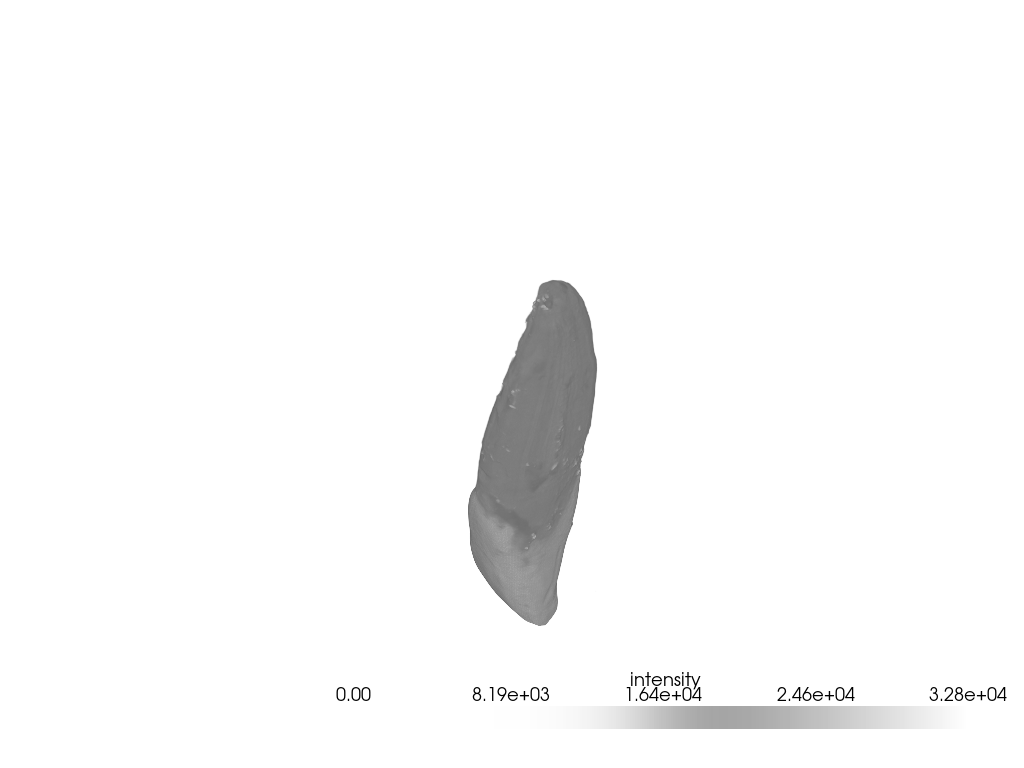

In [14]:
p = pv.Plotter()
p.add_volume(full, cmap="gray", opacity="sigmoid")
p.show()

In [15]:
first_mid_merged_without_overlap_and_shift = merging(Is[1][0], Is[0][0], -1, True)
full_merged_without_overlap_and_shift = merging(first_mid_merged_without_overlap_and_shift, Is[2][0], 0, False)
full_without_overlap_and_shift = numpy_to_pyvista_image(full_merged_without_overlap_and_shift, Is[0][1]['scaling'])

first_mid_merged_without_shift = merging(Is[1][0], Is[0][0], first_mid_idx, True)
full_merged_without_shift = merging(first_mid_merged_without_shift, Is[2][0], mid_last_idx, False)
full_wo_shift = numpy_to_pyvista_image(full_merged_without_shift, Is[0][1]['scaling'])

Text(0.5, 1.0, 'full_merged_with_shift')

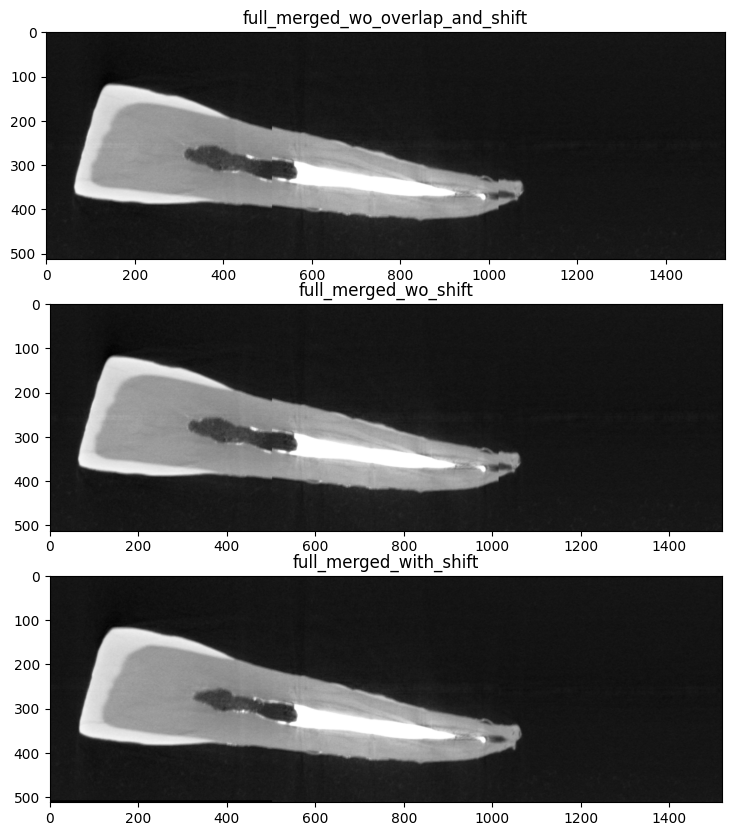

In [17]:
fig, ax = plt.subplots(3, 1, figsize = (15, 10))

ax[0].imshow(full_merged_without_overlap_and_shift[:,256,:],cmap='Greys_r')
ax[0].set_title("full_merged_wo_overlap_and_shift")
ax[1].imshow(full_merged_without_shift[:,256,:],cmap='Greys_r')
ax[1].set_title("full_merged_wo_shift")
ax[2].imshow(full_merged[:,256,:],cmap='Greys_r')
ax[2].set_title("full_merged_with_shift")